In [1]:
import pyspark
from pyspark.sql import SparkSession
import os

# import secrets
NESSIE_URI = os.environ.get("NESSIE_URI") 
WAREHOUSE = os.environ.get("WAREHOUSE")
AWS_ACCESS_KEY = os.environ.get("AWS_ACCESS_KEY") 
AWS_SECRET_KEY = os.environ.get("AWS_SECRET_KEY") 
AWS_S3_ENDPOINT= os.environ.get("AWS_S3_ENDPOINT")

conf = (
    pyspark.SparkConf()
        .setAppName('app_name')
        .set('spark.jars.packages', 'org.apache.iceberg:iceberg-spark-runtime-3.3_2.12:1.3.1,org.projectnessie.nessie-integrations:nessie-spark-extensions-3.3_2.12:0.67.0,software.amazon.awssdk:bundle:2.17.178,software.amazon.awssdk:url-connection-client:2.17.178')
        .set('spark.sql.extensions', 'org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions,org.projectnessie.spark.extensions.NessieSparkSessionExtensions')
        .set('spark.sql.catalog.nessie', 'org.apache.iceberg.spark.SparkCatalog')
        .set('spark.sql.catalog.nessie.uri', NESSIE_URI)
        .set('spark.sql.catalog.nessie.ref', 'main')
        .set('spark.sql.catalog.nessie.authentication.type', 'NONE')
        .set('spark.sql.catalog.nessie.catalog-impl', 'org.apache.iceberg.nessie.NessieCatalog')
        .set('spark.sql.catalog.nessie.s3.endpoint', AWS_S3_ENDPOINT)
        .set('spark.sql.catalog.nessie.warehouse', WAREHOUSE)
        .set('spark.sql.catalog.nessie.io-impl', 'org.apache.iceberg.aws.s3.S3FileIO')
        .set('spark.hadoop.fs.s3a.access.key', AWS_ACCESS_KEY)
        .set('spark.hadoop.fs.s3a.secret.key', AWS_SECRET_KEY)
)

# start a spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Running")

# create a sample table
spark.sql("CREATE TABLE nessie.names (name STRING) USING iceberg;").show()

# insert some data
spark.sql("INSERT INTO nessie.names VALUES ('Alex Merced'), ('Zach Wilson'), ('Ivan Ivanov')").show()

# query the data
spark.sql("SELECT * FROM nessie.names").show()

:: loading settings :: url = jar:file:/home/docker/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/docker/.ivy2/cache
The jars for the packages stored in: /home/docker/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.3_2.12 added as a dependency
org.projectnessie.nessie-integrations#nessie-spark-extensions-3.3_2.12 added as a dependency
software.amazon.awssdk#bundle added as a dependency
software.amazon.awssdk#url-connection-client added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-61f14396-19d2-4762-938c-61c1eccfcd27;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.3_2.12;1.3.1 in central
	found org.projectnessie.nessie-integrations#nessie-spark-extensions-3.3_2.12;0.67.0 in central
	found software.amazon.awssdk#bundle;2.17.178 in central
	found software.amazon.eventstream#eventstream;1.0.1 in central
	found software.amazon.awssdk#url-connection-client;2.17.178 in central
	found software.amazon.awssdk#utils;2.17.178 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central

24/12/11 07:48:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Running


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


++
||
++
++



++
||
++
++



+-----------+
|       name|
+-----------+
|Alex Merced|
|Zach Wilson|
|Ivan Ivanov|
+-----------+



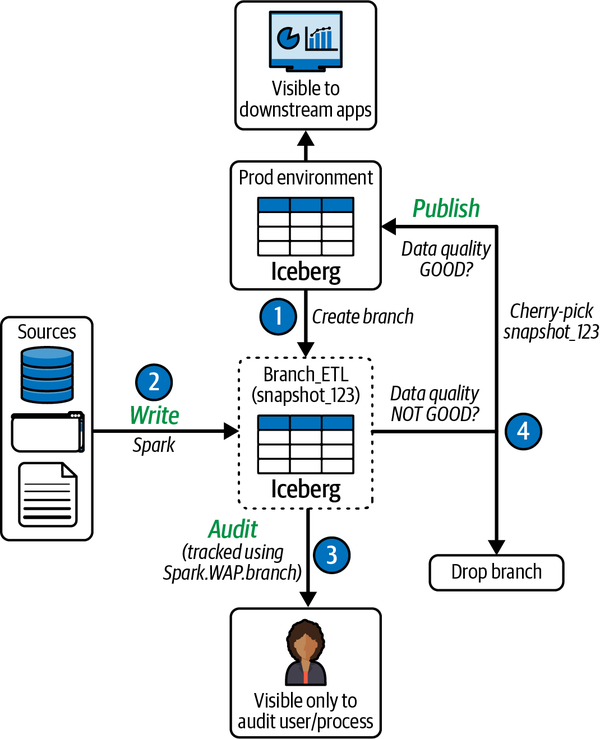

*Source: Apache Iceberg: The Definitive Guide - Chapter 10*

### Steps in the graph

1. Create a branch 
2. Write the newly coming data to that branch
3. Audit the data on that new branch
4. Apply fixes if needed
5. Publish the data

### 0. Exercise setup

In [2]:
df = spark.read.csv("sampledata/Worker_Coops.csv", header=True, inferSchema=True)

In [3]:
df.printSchema()

root
 |-- Business Name (DBA): string (nullable = true)
 |-- Address1: string (nullable = true)
 |-- Address2: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- NAICS Code: string (nullable = true)
 |-- Number of Worker-Owners: integer (nullable = true)
 |-- Number of Non-Member Worker-Owners: integer (nullable = true)
 |-- Subtype: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- City Council: integer (nullable = true)
 |-- Census Tract: integer (nullable = true)
 |-- BIN: integer (nullable = true)
 |-- BBL: long (nullable = true)
 |-- NTA: string (nullable = true)



#### Create an iceberg table and insert sample data

For the sake of the exercise, we create this table and insert some data in it. However, we can image the table already exists in production and we want to add new data to it, and before we add it we need to go through the WAP process.

In [4]:
spark.sql("""
CREATE TABLE nessie.businessdata (
    `Business Name (DBA)` STRING,
    `Address1` STRING,
    `Address2` STRING,
    `City` STRING,
    `State` STRING,
    `Zip` STRING,
    `Community Board` STRING,
    `NAICS Code` STRING,
    `Number of Worker-Owners` INT,
    `Number of Non-Member Worker-Owners` INT,
    `Subtype` STRING,
    `Borough` STRING,
    `Latitude` DOUBLE,
    `Longitude` DOUBLE,
    `City Council` INT,
    `Census Tract` INT,
    `BIN` INT,
    `BBL` BIGINT,
    `NTA` STRING
) USING iceberg;
""")

DataFrame[]

In [5]:
df_pre, df_new = df.randomSplit([0.5, 0.5], seed=42)

df_pre.writeTo("nessie.businessdata").append()

In [6]:
# check the data is in
spark.sql("""SELECT * FROM nessie.businessdata""").show(1)

+-------------------+---------------+--------+--------+-----+-----+---------------+--------------------+-----------------------+----------------------------------+--------+--------+---------+---------+------------+------------+-------+----------+----------------+
|Business Name (DBA)|       Address1|Address2|    City|State|  Zip|Community Board|          NAICS Code|Number of Worker-Owners|Number of Non-Member Worker-Owners| Subtype| Borough| Latitude|Longitude|City Council|Census Tract|    BIN|       BBL|             NTA|
+-------------------+---------------+--------+--------+-----+-----+---------------+--------------------+-----------------------+----------------------------------+--------+--------+---------+---------+------------+------------+-------+----------+----------------+
|          ActionOSH|443 39th Street|    null|Brooklyn|   NY|11232|     7 BROOKLYN|Educational Suppo...|                      3|                                 1|Coaching|BROOKLYN|40.652001|-74.00511|       

We are ready to start the WAP exercise by following the steps from the graph from above

### 1. Create a new branch off of production

In [145]:
# create a new branch on the table called 'dq_branch'
spark.sql("ALTER TABLE nessie.businessdata CREATE BRANCH dq_branch").show()

24/12/11 08:49:08 WARN BaseTransaction: Failed to load metadata for a committed snapshot, skipping clean-up
++
||
++
++



In [146]:
# we can check the branches available for the table. At the moment they are the same as no changes are made
spark.sql("SELECT * FROM nessie.businessdata.refs").show()

+---------+------+-------------------+-----------------------+---------------------+----------------------+
|     name|  type|        snapshot_id|max_reference_age_in_ms|min_snapshots_to_keep|max_snapshot_age_in_ms|
+---------+------+-------------------+-----------------------+---------------------+----------------------+
|     main|BRANCH|3872957193495449871|                   null|                 null|                  null|
|dq_branch|BRANCH|3872957193495449871|                   null|                 null|                  null|
+---------+------+-------------------+-----------------------+---------------------+----------------------+



In [147]:
# get a count of all records in the table BEFORE the new data comes in (just for reference)
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata").show()

+-------------+
|total_records|
+-------------+
|          154|
+-------------+



### 2. Write new data

In [148]:
# setting the table for WAP
spark.conf.set('spark.wap.branch', 'dq_branch')

# enable the Apache Iceberg WAP feature
spark.sql("ALTER TABLE nessie.businessdata SET TBLPROPERTIES ('write.wap.enabled'='true')")

DataFrame[]

In [149]:
df_new.createOrReplaceTempView("temp_new_data")
spark.sql("INSERT INTO nessie.businessdata SELECT * FROM temp_new_data")

DataFrame[]

In [150]:
# check the data is inserted by checking the row count
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata").show()

+-------------+
|total_records|
+-------------+
|          298|
+-------------+



In [151]:
# lets confirm that we only inserted data on the dq_branch
# the count in the main branch should be the same as before (154)
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata VERSION AS OF 'main'").show()

+-------------+
|total_records|
+-------------+
|          154|
+-------------+



In [152]:
# and the count on the dq_branch should be higher
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata VERSION AS OF 'dq_branch'").show()

+-------------+
|total_records|
+-------------+
|          298|
+-------------+



### 3. Audit the data

In [153]:
from pyspark.sql import functions as F

# load the data
df_dq = spark.read.option("branch", "dq_branch") \
    .format("iceberg") \
    .load("nessie.businessdata")

# check for nulls
null_counts = df_dq.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_dq.columns])

null_counts.show()

+-------------------+--------+--------+----+-----+---+---------------+----------+-----------------------+----------------------------------+-------+-------+--------+---------+------------+------------+---+---+---+
|Business Name (DBA)|Address1|Address2|City|State|Zip|Community Board|NAICS Code|Number of Worker-Owners|Number of Non-Member Worker-Owners|Subtype|Borough|Latitude|Longitude|City Council|Census Tract|BIN|BBL|NTA|
+-------------------+--------+--------+----+-----+---+---------------+----------+-----------------------+----------------------------------+-------+-------+--------+---------+------------+------------+---+---+---+
|                  0|       9|     289|  11|   11| 11|             35|        24|                     43|                               198|     21|     34|      34|       34|          34|          34| 34| 34| 34|
+-------------------+--------+--------+----+-----+---+---------------+----------+-----------------------+----------------------------------+----

In [154]:
# check for duplicates
duplicates = df_dq.groupBy(df_dq.columns).count()
duplicates = duplicates.filter(F.col("count") > 1)
duplicates = duplicates.drop("count")
duplicates.show()

+-------------------+--------+--------+----+-----+---+---------------+----------+-----------------------+----------------------------------+-------+-------+--------+---------+------------+------------+---+---+---+
|Business Name (DBA)|Address1|Address2|City|State|Zip|Community Board|NAICS Code|Number of Worker-Owners|Number of Non-Member Worker-Owners|Subtype|Borough|Latitude|Longitude|City Council|Census Tract|BIN|BBL|NTA|
+-------------------+--------+--------+----+-----+---+---------------+----------+-----------------------+----------------------------------+-------+-------+--------+---------+------------+------------+---+---+---+
+-------------------+--------+--------+----+-----+---+---------------+----------+-----------------------+----------------------------------+-------+-------+--------+---------+------------+------------+---+---+---+



In [155]:
# check all boroughs are expected
expected_boroughs = ['null', 'QUEENS', 'BROOKLYN', 'BRONX', 'STATEN IS', 'MANHATTAN']

invalid_boroughs = df_dq.filter(~F.col('borough').isin(expected_boroughs))

if invalid_boroughs.count() > 0:
    print("There are invalid borough values in the DataFrame.")
    invalid_boroughs.show()
else:
    print("All borough values are valid.")

All borough values are valid.


### 4. Apply fixes

In [156]:
# drop nulls ~ etc

In [157]:
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata VERSION AS OF 'dq_branch'").show()

+-------------+
|total_records|
+-------------+
|          298|
+-------------+



In [158]:
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata VERSION AS OF 'main'").show()

+-------------+
|total_records|
+-------------+
|          154|
+-------------+



### 5. Publish

In [159]:
spark.sql("SELECT * FROM nessie.businessdata.refs").show()

+---------+------+-------------------+-----------------------+---------------------+----------------------+
|     name|  type|        snapshot_id|max_reference_age_in_ms|min_snapshots_to_keep|max_snapshot_age_in_ms|
+---------+------+-------------------+-----------------------+---------------------+----------------------+
|     main|BRANCH|3872957193495449871|                   null|                 null|                  null|
|dq_branch|BRANCH|6016868418583876394|                   null|                 null|                  null|
+---------+------+-------------------+-----------------------+---------------------+----------------------+



In [160]:
spark.sql("CALL nessie.system.cherrypick_snapshot('nessie.businessdata',6016868418583876394)").show()

24/12/11 08:50:46 WARN BaseTransaction: Failed to load metadata for a committed snapshot, skipping clean-up
+-------------------+-------------------+
| source_snapshot_id|current_snapshot_id|
+-------------------+-------------------+
|6016868418583876394|6016868418583876394|
+-------------------+-------------------+



In [166]:
spark.sql("SELECT COUNT(*) as total_records FROM nessie.businessdata").show()

+-------------+
|total_records|
+-------------+
|          298|
+-------------+



In [162]:
# end wap session
spark.conf.unset('spark.wap.branch')

In [163]:
spark.sql("ALTER TABLE nessie.businessdata DROP BRANCH `dq_branch`")

24/12/11 08:51:10 WARN BaseTransaction: Failed to load metadata for a committed snapshot, skipping clean-up


DataFrame[]